In [84]:
import numpy as np
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt
import matplotlib.image as image
plt.rcParams["figure.figsize"] = (5,3)

In [85]:
def moving_average(array, interval=50):
    sliding_score = np.zeros(len(array))
    for t in range(len(array)):
        sliding_score[t] = np.mean(array[max(0,t-interval):(t+1)])
    return sliding_score

In [175]:
class QLearning:
    def __init__(self, 
                 n_epochs=1000, 
                 eps=1, 
                 eps_decay_type='lin',
                 alpha=0.4, 
                 gamma=0.9,
                 eps_decay=0.999):
        
        # lookup matrix (pos.x, pos.y, coin_flag, value corresp to action)
        self.Q = np.zeros(shape=(env.field.shape[0], env.field.shape[1], 2, 4)) # np.array of the field's shape
        self.eps = eps # epsilon as in epsilon-greedy policy
        self.eps_decay = eps_decay # ???
        self.eps_decay_type = eps_decay_type
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.n_epochs = n_epochs
    
    def update_Q(self, s_t, a_t, reward, s_next):
        self.Q[s_t[0], s_t[1], s_t[2], a_t] += self.alpha * \
                    (reward + self.gamma*np.max(self.Q[s_next[0], s_next[1], s_next[2]]) - self.Q[s_t[0], s_t[1], s_t[2], a_t])
    
    def get_best_action(self, s_t):
        return np.argmax(self.Q[s_t[0], s_t[1], s_t[2]])
    
    def train(self, env):
        self.env = env
        self.scores = np.zeros(self.n_epochs)
        self.eps_vals = np.zeros(self.n_epochs)
        self.coins_collected = np.zeros(self.n_epochs)
        for epoch in tqdm(range(self.n_epochs)):
            s_t = self.env.reset()
            done = False
            score = 0
            while not done:
                action = self.env.action_space.sample() if np.random.random() < self.eps else self.get_best_action(s_t)
                s_next, reward, done, info = self.env.step(action)
#                 print(s_next, f, reward, done, info)
                self.update_Q(s_t, action, reward, s_next)
                s_t = s_next
                score += reward
            
            self.coins_collected[epoch] = len(self.env.coins_collected)
            self.scores[epoch] = score
            
            if self.eps_decay_type == 'lin':
                self.eps -= 1/(self.n_epochs) if self.eps > 0.01 else 0 # linear
            elif self.eps_decay_type == 'exp':
                self.eps *= self.eps_decay if self.eps > 0.15 else 1 # exponential
            else:
                raise Exception('Unknown eps decay type specifier:', self.eps_decay_type)
            self.eps_vals[epoch] = self.eps
    
    def solve(self):
        s_tmp = self.env.reset()
        s = tuple(s_tmp[:-1])
        e = self.env.exits
        path = []
        cnt = 0
        while s not in e:
            path.append(s)
            action = self.get_best_action(s_tmp)
            s_tmp, _, _, _ = self.env.step(action)
            s = tuple(s_tmp[:-1])
            cnt+=1
            if cnt > self.env.WIDTH * self.env.HEIGHT:
                raise Exception('Agent failed to converge')
        return path[1:]


## Init and training

In [181]:
img = image.imread('tracks/track3_mod2.png')[:,:,:3]

In [182]:
%run maze_RL.ipynb
env = MazeEnvironment(img)

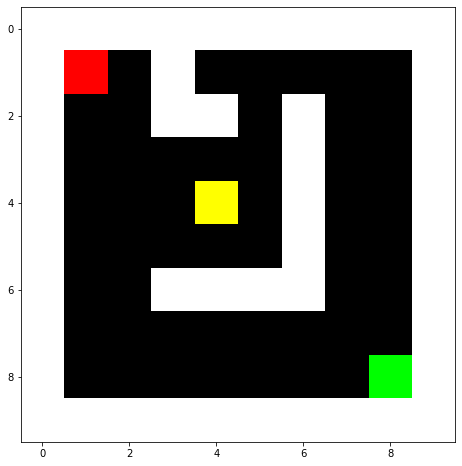

In [183]:
env.render()

In [184]:
model = QLearning(n_epochs=20000) #, eps=1, eps_decay=0.99, alpha=0.5)

In [ ]:
model.train(env)

 78%|█████████████████████████████████████████████████████████▎                | 15500/20000 [00:05<00:03, 1180.31it/s]

In [136]:
model.Q[4,4,0]

array([14.19159025, 24.51916557, 24.00040255, 19.05224099])

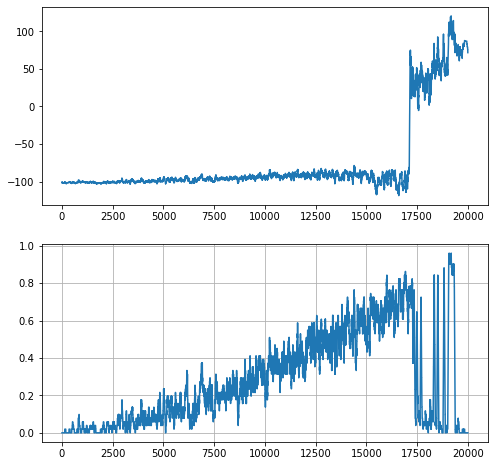

In [165]:
fig, axs = plt.subplots(2)
axs[0].plot(moving_average(model.scores))
axs[1].plot(moving_average(model.coins_collected))
plt.grid()
plt.show()

In [166]:
optimal_path = model.solve()

In [167]:
optimal_path

[(1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (8, 6),
 (8, 7)]

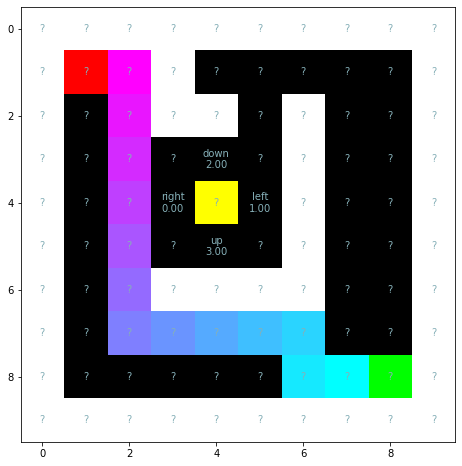

In [169]:
env.render(model, show_labels=True, flag=1)

with open('weights/track2_fucker_collects_one_single_coin.pickle', 'wb') as f:
    pickle.dump(model, file=f)

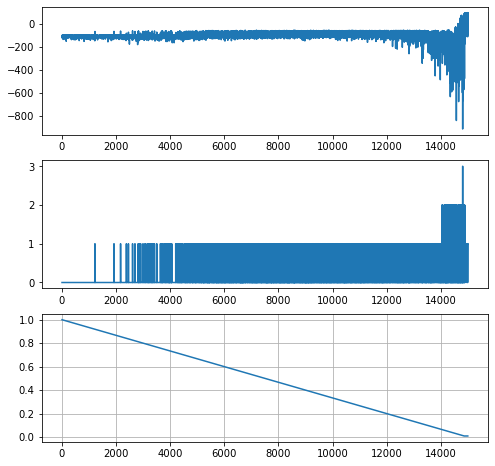

In [19]:
fig, axs = plt.subplots(3)
axs[0].plot(model.scores)
axs[1].plot(model.coins_collected)
axs[2].plot(model.eps_vals)
plt.grid()
plt.show()